# **Explorando el Protocolo de Contexto de Modelo (MCP) en Pydantic AI**  

En esta notebook aprenderemos qué es el **Protocolo de Contexto de Modelo (MCP)** y cómo **Pydantic AI** lo soporta para potenciar la interacción entre agentes de IA y herramientas externas.  

El MCP es un **estándar de comunicación** que permite que aplicaciones de IA —como agentes programáticos, editores de código o interfaces gráficas— se conecten a **servicios y herramientas externas** mediante una interfaz común, evitando integraciones personalizadas.  

Veremos las tres formas en las que Pydantic AI trabaja con MCP:  
1. **Agentes como clientes MCP**, aprovechando servidores MCP para acceder a herramientas externas.  
2. **Agentes integrados dentro de servidores MCP**, expandiendo sus capacidades.  
3. **Servidores MCP desarrollados como parte de Pydantic AI**, como el servidor *Run Python* para ejecutar código en entornos aislados.  

## ¿Qué es el Protocolo de Contexto de Modelo (MCP)?

El [Protocolo de Contexto de Modelo (MCP)](https://github.com/modelcontextprotocol) es un estándar abierto diseñado para facilitar la integración entre aplicaciones de modelos de lenguaje grande (LLM) y fuentes de datos o herramientas externas. Este protocolo proporciona una forma estandarizada de conectar aplicaciones LLM con el contexto que necesitan, ya sea para desarrollar un IDE basado en IA, mejorar una interfaz de chat o crear flujos de trabajo de IA personalizados.

### Empezando con MCP

Para comenzar a trabajar con MCP, puedes acceder a los siguientes recursos:

- 📚 [Documentación oficial](https://modelcontextprotocol.io): Guías y tutoriales para ayudarte a empezar.
- 🔍 [Especificación del protocolo](https://spec.modelcontextprotocol.io): Detalles técnicos del protocolo.
- 💻 SDKs disponibles: Herramientas para comenzar a construir en diferentes lenguajes de programación:

  - [TypeScript SDK](https://github.com/modelcontextprotocol/typescript-sdk)
  - [Python SDK](https://github.com/modelcontextprotocol/python-sdk)
  - [Java SDK](https://github.com/modelcontextprotocol/java-sdk)
  - [Kotlin SDK](https://github.com/modelcontextprotocol/kotlin-sdk)
  - [C# SDK](https://github.com/modelcontextprotocol/csharp-sdk)

### Estructura del proyecto MCP

El repositorio de MCP en GitHub está organizado de la siguiente manera:

- `specification`: Especificación y documentación del protocolo.
- `typescript-sdk`: Implementación en TypeScript.
- `python-sdk`: Implementación en Python.
- `java-sdk`: Implementación en Java.
- `kotlin-sdk`: Implementación en Kotlin.
- `csharp-sdk`: Implementación en C#.
- `docs`: Documentación y guías de usuario.
- `create-kotlin-server`: Servidor de muestra en Kotlin.
- `servers`: Lista de servidores MCP mantenidos.

Para más información y para contribuir al proyecto, visita el [repositorio oficial de MCP en GitHub](https://github.com/modelcontextprotocol).


## Agentes como clientes MCP

Necesitas instalar `pydantic-ai` o `pydantic-ai-slim` con el grupo opcional `mcp`:

```bash
uv add "pydantic-ai-slim[mcp]"
```

### Uso de Pydantic AI con servidores MCP

Pydantic AI ofrece tres formas principales de conectarse a servidores MCP:

- **MCPServerStreamableHTTP**: conecta a un servidor MCP usando transporte HTTP con streaming.  
- **MCPServerSSE**: conecta a un servidor MCP usando transporte HTTP SSE (Server-Sent Events).  
- **MCPServerStdio**: ejecuta el servidor como un proceso hijo y se conecta a él mediante transporte stdio (entrada/salida estándar).  

En todos los ejemplos, se utiliza `mcp-run-python` como servidor MCP.

Cada instancia de servidor MCP funciona como un conjunto de herramientas (toolset) y puede registrarse en un agente mediante el argumento `toolsets`.

Para administrar conexiones, se recomienda usar el manejador de contexto asíncrono `async with agent`, que abre y cierra las conexiones a todos los servidores registrados y, en el caso de servidores stdio, inicia y detiene los procesos hijos, durante el tiempo que se usen en la ejecución del agente.  

También puedes usar `async with server` para manejar la conexión o proceso de un servidor específico, útil si quieres usar el mismo servidor con múltiples agentes.

Si no se usa explícitamente un manejador de contexto para configurar el servidor, Pydantic AI lo hará automáticamente cuando sea necesario (por ejemplo, para listar herramientas disponibles o ejecutar una herramienta), pero es más eficiente abrir y cerrar la conexión alrededor de todo el bloque de código donde se usará el servidor.


### MCPServerStreamableHTTP

Antes de crear el cliente HTTP con streaming, necesitamos ejecutar un servidor que soporte el transporte **Streamable HTTP**.


In [1]:
!cat mcp/streamable_http_server.py

import math
from datetime import datetime
from mcp.server.fastmcp import FastMCP

app = FastMCP()

@app.tool()
def calcular_interes_compuesto(principal: float, tasa: float, periodos: int) -> float:
    """
    Calcula el valor final con interés compuesto.

    - principal: Monto inicial
    - tasa: Tasa de interés anual en porcentaje (ej. 5.0)
    - periodos: Número de años
    """
    return principal * (1 + tasa / 100) ** periodos


@app.tool()
def polar_a_cartesiana(radio: float, angulo_grados: float) -> tuple:
    """
    Convierte coordenadas polares a cartesianas (x, y).
    """
    angulo_radianes = math.radians(angulo_grados)
    x = radio * math.cos(angulo_radianes)
    y = radio * math.sin(angulo_radianes)
    return (x, y)


@app.tool()
def factorial(n: int) -> int:
    """
    Calcula el factorial de un número entero positivo.
    """
    if n < 0:
        raise ValueError("El número debe ser positivo.")
    resultado = 1
    for i in range(2, n + 1):
        resultado *= i

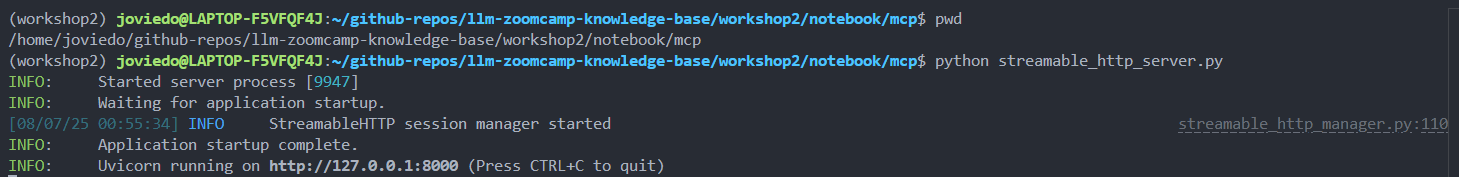

**Inicializar notebook**

Ejecuta estas celdas antes de comenzar. Incluyen funciones clave y configuración necesaria para que el resto del notebook funcione correctamente.

In [2]:
from dotenv import load_dotenv
import os
import logging

load_dotenv()

# Validar cargar de variables de entornos necesarias
if not os.getenv("OPENAI_API_KEY"):
    print("Error: La variable de entorno OPENAI_API_KEY no está definida.")

print("OPENAI_API_KEY cargada correctamente.")

if not os.getenv("LOGFIRE_API_KEY"):
    print("Error: La variable de entorno LOGFIRE_API_KEY no está definida.")

print("LOGFIRE_API_KEY cargada correctamente.")

# Desactiva mensajes de logging de nivel INFO
logging.getLogger().setLevel(logging.WARNING)

OPENAI_API_KEY cargada correctamente.
LOGFIRE_API_KEY cargada correctamente.


#### **¿Qué es Logfire?**

**Logfire** es una herramienta de observabilidad para aplicaciones modernas que facilita el monitoreo de logs, métricas y trazas desde tus scripts o servicios. Se integra de forma sencilla con librerías populares de Python como **PydanticAI**, lo que permite capturar automáticamente eventos y métricas de ejecución, sin agregar complejidad adicional al código.

Logfire es especialmente útil cuando estás desarrollando agentes, workflows o aplicaciones impulsadas por LLMs (modelos de lenguaje), ya que te permite ver qué datos están siendo procesados, qué decisiones se toman, y cómo fluye la información a través del sistema.

[Documentación oficial](https://logfire.pydantic.dev/docs/)

Estas líneas configuran Logfire y habilitan la integración con PydanticAI para capturar eventos automáticamente.

In [3]:
import logfire

logfire.configure()
logfire.instrument_pydantic_ai()

Logfire project URL: ]8;id=987726;https://logfire-us.pydantic.dev/j92riquelme/test-pydanticai\https://logfire-us.pydantic.dev/j92riquelme/test-pydanticai]8;;\

Currently retrying 1 failed export(s)


In [4]:
import asyncio
from pydantic_ai import Agent
from pydantic_ai.mcp import MCPServerStreamableHTTP

server = MCPServerStreamableHTTP('http://localhost:8000/mcp')  
agent = Agent('openai:gpt-4o-mini', toolsets=[server])  

async def main():
    async with agent:
        prompts = [
            "How many days between 2000-01-01 and 2025-03-18?",
            "Convert polar coordinates (5, 45 degrees) to cartesian.",
            "What is the compound interest for 1000 dollars at 5% in 10 years?",
            "Calculate the distance between Asunción and Buenos Aires.",
            "What's the factorial of 7?",
            "List the available tools"
        ]

        for prompt in prompts:
            print(f"🧠 Consulta: {prompt}")
            result = await agent.run(prompt)
            print(f"✅ Respuesta: {result.output}\n")

In [6]:
await main()

🧠 Consulta: How many days between 2000-01-01 and 2025-03-18?
10:34:40.001 agent run
10:34:40.009   chat gpt-4o-mini
10:34:41.946   running 1 tool
10:34:41.946     running tool: calculate_days_between_dates
10:34:41.962   chat gpt-4o-mini
✅ Respuesta: There are 9,208 days between January 1, 2000, and March 18, 2025.

🧠 Consulta: Convert polar coordinates (5, 45 degrees) to cartesian.
10:34:43.815 agent run
10:34:43.823   chat gpt-4o-mini
10:34:44.918   running 1 tool
10:34:44.918     running tool: polar_a_cartesiana
10:34:44.933   chat gpt-4o-mini
✅ Respuesta: The Cartesian coordinates corresponding to the polar coordinates (5, 45 degrees) are approximately (3.54, 3.54).

🧠 Consulta: What is the compound interest for 1000 dollars at 5% in 10 years?
10:34:46.140 agent run
10:34:46.148   chat gpt-4o-mini
10:34:47.479   running 1 tool
10:34:47.480     running tool: calcular_interes_compuesto
10:34:47.502   chat gpt-4o-mini
✅ Respuesta: The compound interest for 1000 dollars at a 5% annual 

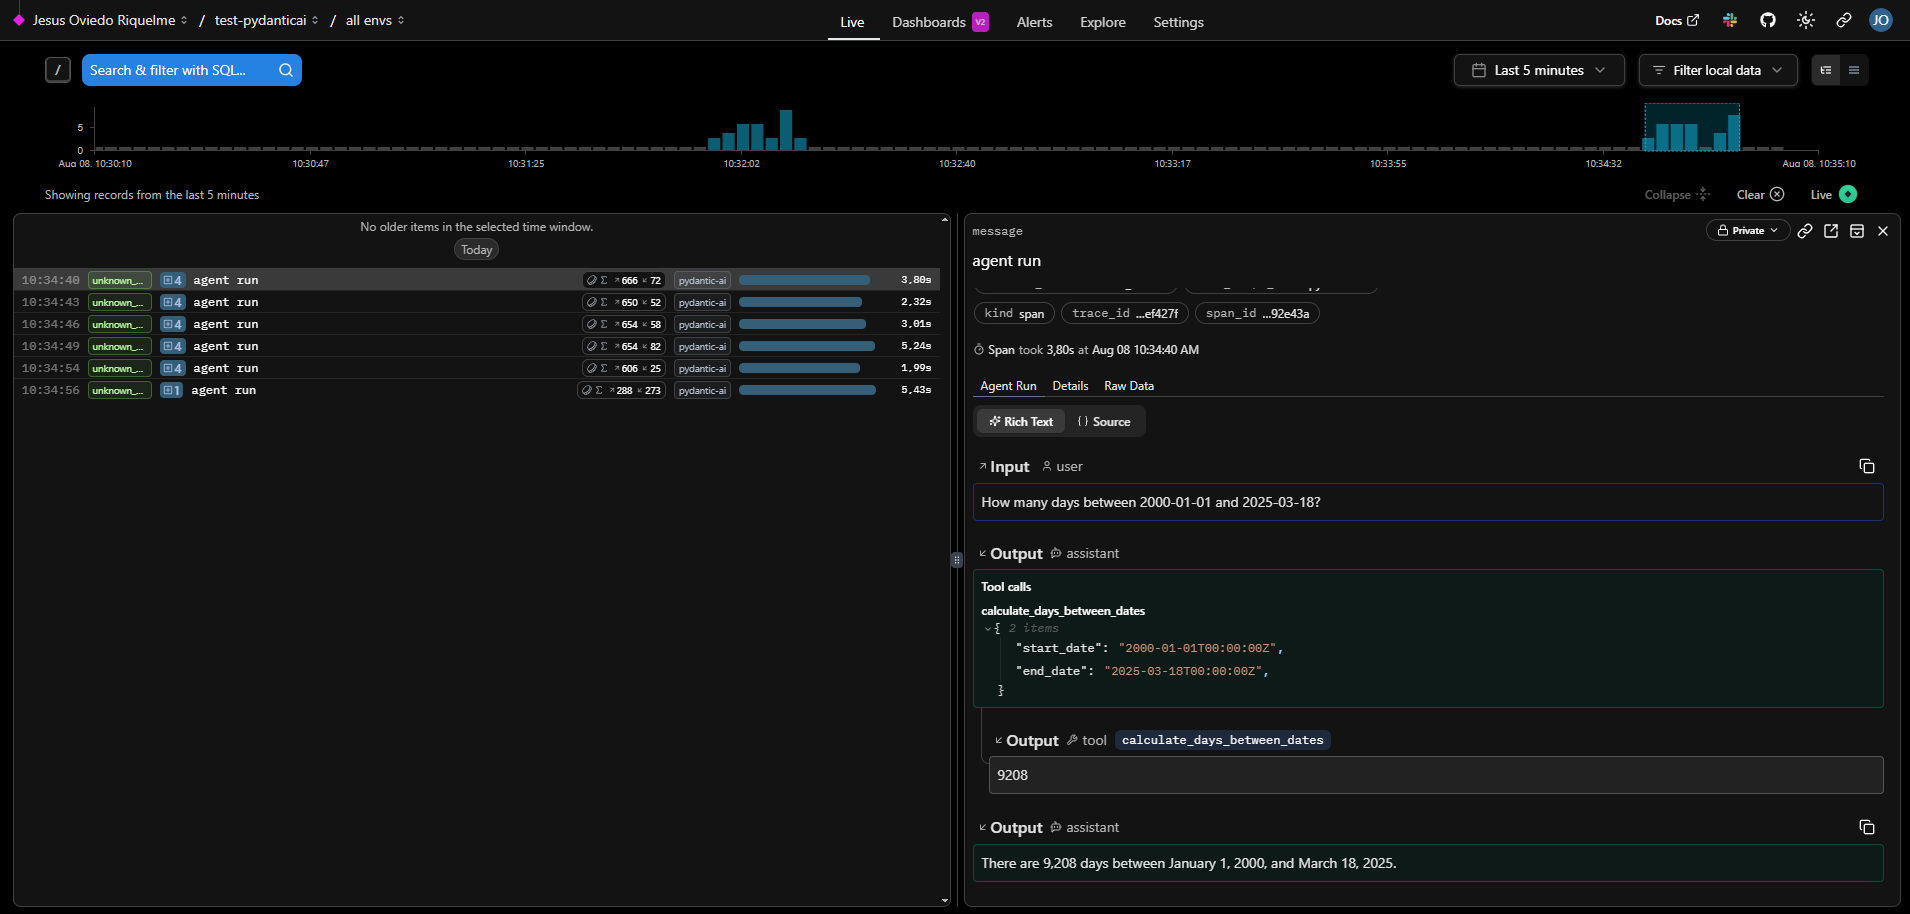

### MCPServerSSE

Para ejecutar el servidor **`MCPServerSSE`**, que es el servidor que permite a un agente con arquitectura MCP (Modular Chat Programming) comunicarse en modo *streaming* (Server-Sent Events), necesitas **Deno**, ya que el paquete que provee este servidor está desarrollado usando este entorno.

#### **¿Qué es Deno?**

**[Deno](https://deno.com/)** es un entorno de ejecución moderno para JavaScript y TypeScript creado por Ryan Dahl, el mismo creador de Node.js. Fue diseñado para corregir algunas de las decisiones problemáticas de diseño que tiene Node.js, como:

- **Seguridad por defecto**: Deno no permite acceder al sistema de archivos, red o entorno sin permisos explícitos.
- **Soporte nativo para TypeScript**: No requiere configuración adicional para ejecutar archivos `.ts`.
- **Sistema de módulos basado en URLs**: No usa `node_modules` por defecto.
- **Incluye herramientas integradas** como formateador, linter, test runner y empaquetador.

Deno se puede ver como una alternativa moderna a Node.js, más segura, más sencilla de usar y pensada para la web.


#### **¿Cómo ejecutar `MCPServerSSE`?**

Una vez instalado Deno, puedes iniciar el servidor de streaming con este comando:

```bash
deno run \
  -N -R=node_modules -W=node_modules --node-modules-dir=auto \
  jsr:@pydantic/mcp-run-python sse
```

Explicación de los flags:
* `-N`: Permite acceder a la red (network).
* `-R=node_modules`: Permite leer desde el directorio node_modules.
* `-W=node_modules`: Permite escribir en node_modules.
* `--node-modules-dir=auto`: Gestiona automáticamente el uso de node_modules con compatibilidad JSR/NPM.

Este comando lanza un servidor SSE necesario para probar interacciones streaming desde la notebook o cualquier cliente Python que use la arquitectura MCP.

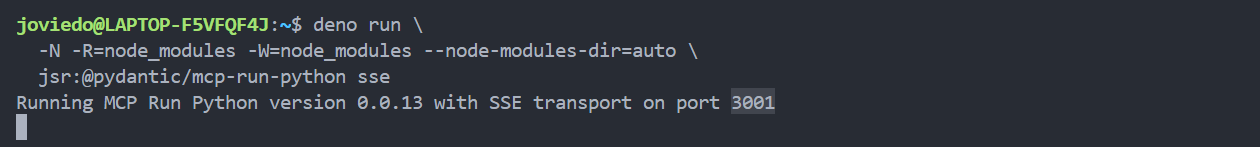

In [7]:
import asyncio
from pydantic_ai import Agent
from pydantic_ai.mcp import MCPServerSSE

server = MCPServerSSE(url='http://localhost:3001/sse')  
agent = Agent('openai:gpt-4o-mini', toolsets=[server])  


async def main():
    async with agent:  
        result = await agent.run('How many days between 2000-01-01 and 2025-03-18?')
    print(result.output)

In [8]:
await main()

10:35:58.863 agent run
10:35:58.868   chat gpt-4o-mini
10:36:01.278   running 1 tool
10:36:01.278     running tool: run_python_code
10:36:04.397   chat gpt-4o-mini
There are 9,208 days between January 1, 2000, and March 18, 2025.


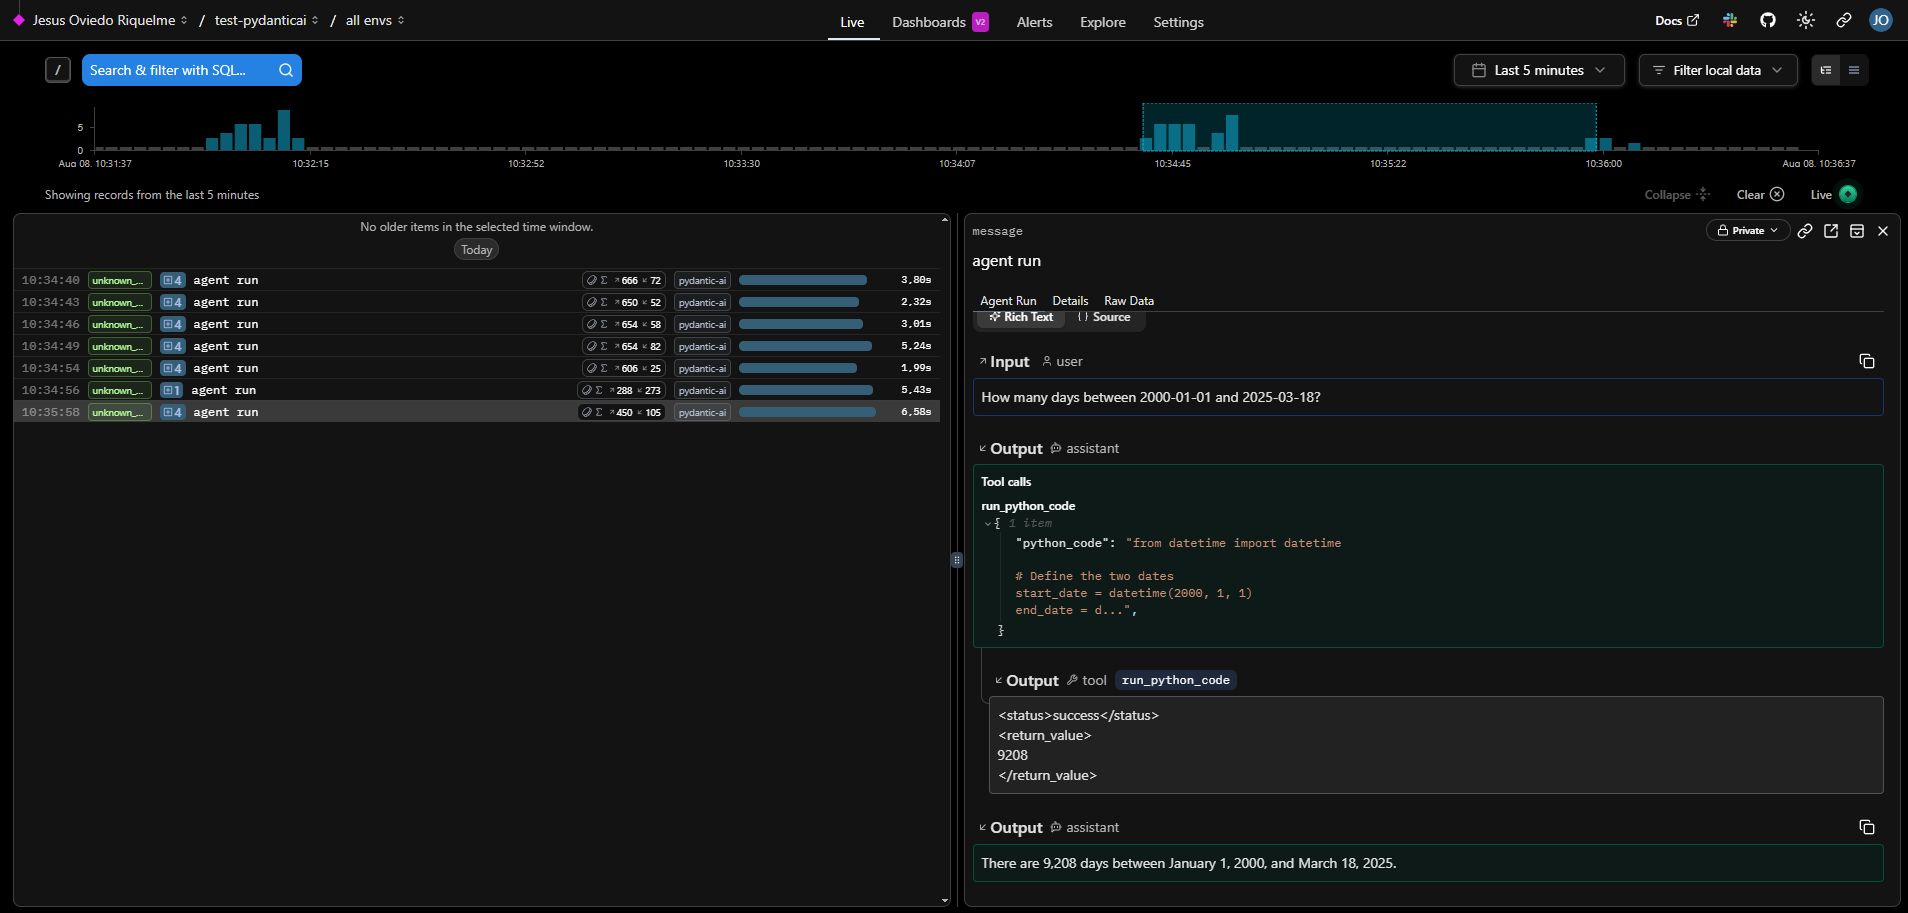

### MCPServerStdio

Además del transporte tradicional, MCP ofrece un modo de transporte llamado **`stdio`**, en el que el servidor se ejecuta como un **subproceso** del cliente y se comunica a través de los flujos **`stdin`** y **`stdout`** del proceso. En este esquema, se utiliza la clase `MCPServerStdio` para establecer y gestionar la comunicación entre cliente y servidor.


In [14]:
from pydantic_ai import Agent
from pydantic_ai.mcp import MCPServerStdio

server = MCPServerStdio(  
    'deno',
    args=[
        'run',
        '-N',
        '-R=node_modules',
        '-W=node_modules',
        '--node-modules-dir=auto',
        'jsr:@pydantic/mcp-run-python',
        'stdio',
    ]
)
agent = Agent('openai:gpt-4o-mini', toolsets=[server])


async def main():
    async with agent:
        result = await agent.run('How many days between 2000-01-01 and 2025-07-12?')
    print(result.output)

In [17]:
await main()

10:53:46.145 agent run
10:53:46.148   chat gpt-4o-mini
10:53:48.247   running 1 tool
10:53:48.248     running tool: run_python_code
10:53:51.856   chat gpt-4o-mini
There are 9,324 days between January 1, 2000, and July 12, 2025.


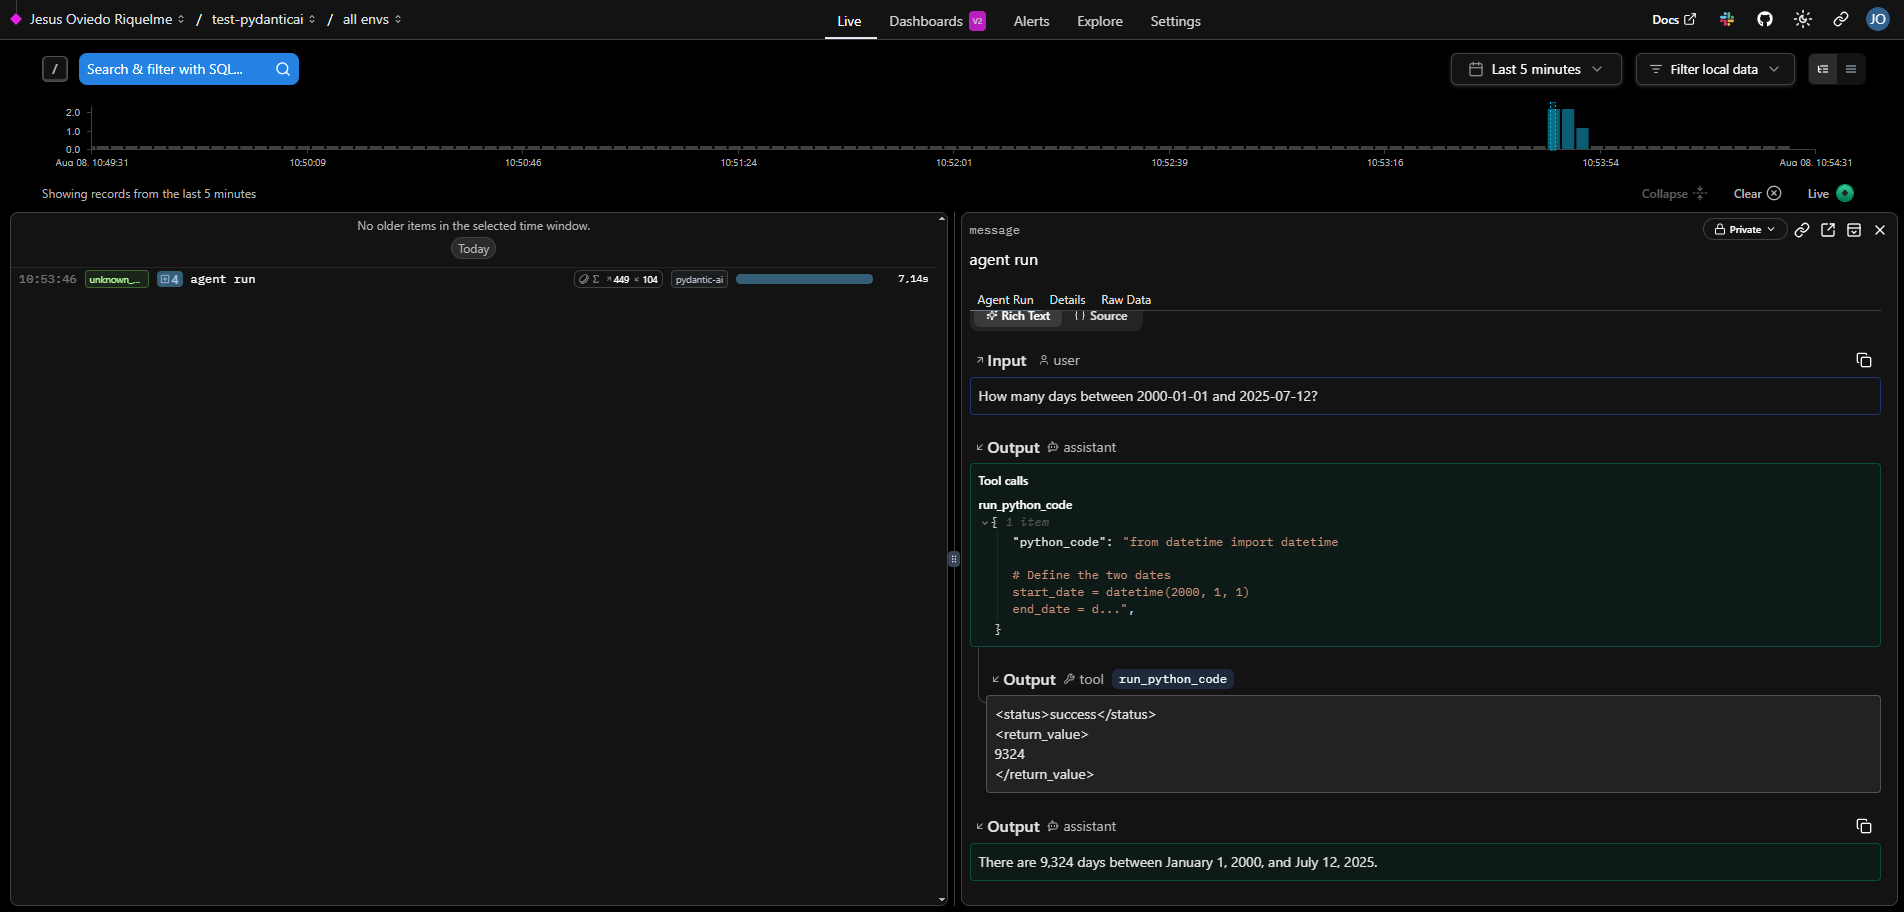

📌 Si quieres continuar con el siguiente tema, el **punto 2** (*Agentes integrados dentro de servidores MCP, expandiendo sus capacidades*) lo puedes encontrar en la siguiente [notebook](./using_mcp_with_pydanticai_part_2.ipynb).